# **Build a Machine Learning model**

**Scenario:** A Taxi company requested to build a machine learning model to predict if a customer will not leave a tip. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips.

**The goal:** Develop a model to predict whether or not a customer is a generous tipper. The target variable is a binary  (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%(0=no, 1=yes).

### **Task 1. Imports and data loading**

In [11]:
# Import packages and libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

import pickle


In [12]:
pd.set_option('display.max_columns', None)

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
# Import data
df0 = pd.read_csv('/content/gdrive/My Drive/Coursera/Data/2017_Yellow_Taxi_Trip_Data.csv')

In [15]:
# Inspect data
df0.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


### **Task 2. Explore data with EDA**

According to another analysis "[regression analysis](https://github.com/functionR150/Portfolio/blob/main/Regression%20Analysis.ipynb)", there are some unusual, extreme data that need to be addressed

In [16]:
# Remove unusual data
mask = ((df0["fare_amount"] < 0) | (df0["extra"] < 0) | (df0["mta_tax"] < 0) | (df0["improvement_surcharge"] < 0) | (df0["total_amount"] < 0))
df0 = df0[~mask]

In [17]:
# Imputations fare_amount outliers

def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    for col in column_list:
        # Reassign minimum to zero
        df0.loc[df0[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df0[col].quantile(0.25)
        q3 = df0[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df0.loc[df0[col] > upper_threshold, col] = upper_threshold
        print(df0[col].describe())
        print()

In [18]:
# Impute the maximum value as Q3 + (6 * IQR).
outlier_imputer(['fare_amount'], 6)

fare_amount
q3: 14.5
upper_threshold: 62.5
count    22685.000000
mean        12.905873
std         10.539517
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64



In [19]:
# Convert datetime columns to datetime
df0["tpep_pickup_datetime"] = pd.to_datetime(df0["tpep_pickup_datetime"])
df0["tpep_dropoff_datetime"] = pd.to_datetime(df0["tpep_dropoff_datetime"])
df0[["tpep_pickup_datetime","tpep_dropoff_datetime"]].info()

# Create `duration` column
df0["duration"] = (df0["tpep_dropoff_datetime"] - df0["tpep_pickup_datetime"]).dt.total_seconds() / 60
df0.head()

<class 'pandas.core.frame.DataFrame'>
Index: 22685 entries, 0 to 22698
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   22685 non-null  datetime64[ns]
 1   tpep_dropoff_datetime  22685 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 531.7 KB


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,16.716667


In [20]:
# Impute the maximum value as Q3 + (6 * IQR).
outlier_imputer(['duration'], 6)

duration
q3: 18.383333333333333
upper_threshold: 88.68333333333331
count    22685.000000
mean        14.464108
std         11.934861
min          0.000000
25%          6.666667
50%         11.183333
75%         18.383333
max         88.683333
Name: duration, dtype: float64



In [21]:
# Create `pickup_dropoff` column
df0["pickup_dropoff"]=df0["PULocationID"].apply(str) + " - " + df0["DOLocationID"].apply(str)

# Caculate the mean duration and mean distance for each group of trips
grouped_distiance_duration = df0[["pickup_dropoff", "trip_distance","duration"]].groupby("pickup_dropoff").mean().reset_index()
grouped_distiance_duration.rename(columns={'trip_distance': 'mean_trip_distance', 'duration': 'mean_duration'}, inplace=True)

# Merge data
df0 = pd.merge(df0, grouped_distiance_duration, on='pickup_dropoff', how='left')
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_trip_distance,mean_duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,100 - 231,3.521667,22.847222
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,186 - 43,3.108889,24.470370
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,262 - 236,0.881429,7.250000
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,188 - 97,3.700000,30.250000
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,16.716667,4 - 112,4.435000,14.616667


### **Task 2. Feature engineering**

From the EDA of another analysis "[regression analysis](https://github.com/functionR150/Portfolio/blob/main/Regression%20Analysis.ipynb)", that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, sample the data to select only the customers who pay with credit card.

In [22]:
# Subset the data to isolate only customers who paid by credit card
mask = df0["payment_type"] == 1
df0 = df0[mask]
df0.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_trip_distance,mean_duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,100 - 231,3.521667,22.847222
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,186 - 43,3.108889,24.470370
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,262 - 236,0.881429,7.250000
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,188 - 97,3.700000,30.250000
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,8.000000,161 - 236,2.052258,11.855376


#### Create tip percent and generous columns

Create a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  


In [23]:
df0["tip_percent"] = (df0["tip_amount"]/(df0["total_amount"]-df0["tip_amount"])).round(3)
df0.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_trip_distance,mean_duration,tip_percent
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,100 - 231,3.521667,22.847222,0.200
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,186 - 43,3.108889,24.470370,0.238
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,262 - 236,0.881429,7.250000,0.199
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,188 - 97,3.700000,30.250000,0.300
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,8.000000,161 - 236,2.052258,11.855376,0.200


Create another column called `generous`. This is the target variable. The column is a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

In [24]:
df0["generous"] = (df0['tip_percent'] >= 0.2).astype(int)
df0.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_trip_distance,mean_duration,tip_percent,generous
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,100 - 231,3.521667,22.847222,0.200,1
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,186 - 43,3.108889,24.470370,0.238,1
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,262 - 236,0.881429,7.250000,0.199,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,188 - 97,3.700000,30.250000,0.300,1
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,8.000000,161 - 236,2.052258,11.855376,0.200,1


#### Create day column

In [25]:
# Convert pickup and dropoff cols to datetime
df0["tpep_pickup_datetime"] = pd.to_datetime(df0['tpep_pickup_datetime'])
df0["tpep_dropoff_datetime"] = pd.to_datetime(df0['tpep_dropoff_datetime'])
# Create a 'day' col
df0["day"] = df0["tpep_pickup_datetime"].dt.day_name().str.lower()

#### Create time of day columns

Engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

In [26]:
#### Create 'am_rush' col
# Define the time period for condition
start_time = pd.to_datetime('06:00:00').time()
end_time = pd.to_datetime('10:00:00').time()

# Create a binary column based on condition
df0['am_rush'] = (df0['tpep_pickup_datetime'].dt.time >= start_time) & (df0['tpep_pickup_datetime'].dt.time < end_time)

# Convert boolean to integer (0 or 1)
df0['am_rush'] = df0['am_rush'].astype(int)

#### Create 'daytime' col
start_time = pd.to_datetime('10:00:00').time()
end_time = pd.to_datetime('16:00:00').time()

# Create a binary column based on condition
df0['daytime'] = (df0['tpep_pickup_datetime'].dt.time >= start_time) & (df0['tpep_pickup_datetime'].dt.time < end_time)

# Convert boolean to integer (0 or 1)
df0['daytime'] = df0['daytime'].astype(int)

### Create 'pm_rush' col
start_time = pd.to_datetime('16:00:00').time()
end_time = pd.to_datetime('20:00:00').time()

# Create a binary column based on condition
df0['pm_rush'] = (df0['tpep_pickup_datetime'].dt.time >= start_time) & (df0['tpep_pickup_datetime'].dt.time < end_time)

# Convert boolean to integer (0 or 1)
df0['pm_rush'] = df0['pm_rush'].astype(int)

### Create 'nighttime' col
start_time = pd.to_datetime('20:00:00').time()
end_time = pd.to_datetime('06:00:00').time()

# Create a binary column based on condition
df0['nighttime'] = (df0['tpep_pickup_datetime'].dt.time >= start_time)

# Convert boolean to integer (0 or 1)
df0['nighttime'] = df0['nighttime'].astype(int)

df0.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_trip_distance,mean_duration,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,100 - 231,3.521667,22.847222,0.200,1,saturday,1,0,0,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,186 - 43,3.108889,24.470370,0.238,1,tuesday,0,1,0,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,262 - 236,0.881429,7.250000,0.199,0,friday,1,0,0,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,188 - 97,3.700000,30.250000,0.300,1,sunday,0,1,0,0
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,8.000000,161 - 236,2.052258,11.855376,0.200,1,saturday,0,0,0,1


#### Create `month` column

In [27]:
# Create 'month' col
df0["month"] = df0["tpep_pickup_datetime"].dt.month_name().str.slice(0, 3)
df0["month"] = df0["month"].str.lower()
df0.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_trip_distance,mean_duration,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.066667,100 - 231,3.521667,22.847222,0.200,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.500000,186 - 43,3.108889,24.470370,0.238,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.200000,262 - 236,0.881429,7.250000,0.199,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,188 - 97,3.700000,30.250000,0.300,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,8.000000,161 - 236,2.052258,11.855376,0.200,1,saturday,0,0,0,1,mar


#### Drop columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed.

In [28]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df0 = df0.drop(drop_cols, axis=1)
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22684
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   VendorID            15265 non-null  int64  
 1   passenger_count     15265 non-null  int64  
 2   RatecodeID          15265 non-null  int64  
 3   PULocationID        15265 non-null  int64  
 4   DOLocationID        15265 non-null  int64  
 5   duration            15265 non-null  float64
 6   pickup_dropoff      15265 non-null  object 
 7   mean_trip_distance  15265 non-null  float64
 8   mean_duration       15265 non-null  float64
 9   generous            15265 non-null  int64  
 10  day                 15265 non-null  object 
 11  am_rush             15265 non-null  int64  
 12  daytime             15265 non-null  int64  
 13  pm_rush             15265 non-null  int64  
 14  nighttime           15265 non-null  int64  
 15  month               15265 non-null  object 
dtypes: float6

In [29]:
#Save data
df0.to_csv('data_for_modeling.csv', index=False)

#### Variable encoding

Convert columns into dummy variable.

In [30]:
# Convert specific INT64 columns to STRING
df0['VendorID'] = df0['VendorID'].astype(str)
df0['RatecodeID'] = df0['RatecodeID'].astype(str)
df0['PULocationID'] = df0['PULocationID'].astype(str)
df0['DOLocationID'] = df0['DOLocationID'].astype(str)

# Convert categoricals to binary
df2 = pd.get_dummies(df0,drop_first = True)

##### Evaluation metric

Decide on an evaluation metric.

In [31]:
# Get class balance of 'generous' col
df2["generous"].value_counts()/df2["generous"].size

generous
1    0.526368
0    0.473632
Name: count, dtype: float64

A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

F1 score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.

### **Task 3. Modeling**

##### **Split the data**

In [32]:
# Isolate target variable (y)
y = df2[["generous"]]

# Isolate the features (X)
X = df2.drop(columns = "generous")

# Split into train and test sets. Put 20% of the samples into the test set, stratify the data, and set the random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### **1st model: RandomForest**


In [33]:
# 1. Instantiate the random forest classifier
model = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, None],
             'max_features': ["sqrt", 1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [100, 300]
             }

# 3. Define a set of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf = GridSearchCV(model, cv_params, cv=4, scoring = scoring, refit = "f1")

In [34]:
%%time
rf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

CPU times: user 1h 3min 35s, sys: 5.49 s, total: 1h 3min 40s
Wall time: 1h 4min 14s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [6, None], 'max_features': ['sqrt', 1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100, 300]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

##### **Save the model**

In [35]:
# Define a path to the folder where you want to save the model
path = '/content/gdrive/My Drive/Coursera/Data/'

In [36]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [37]:
write_pickle(path, rf, "rf")

In [38]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [39]:
rf = read_pickle(path, "rf")
rf

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [6, None], 'max_features': ['sqrt', 1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100, 300]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

##### **Examine the model result**

Examine the best average score across all the validation folds.

In [40]:
rf.best_score_

0.7557546798685799

Examine the best combination of hyperparameters.

In [41]:
rf.best_params_

{'max_depth': 6,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Define the `make_results()` function to output all of the scores of model.

In [42]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [43]:
results = make_results("RF CV", rf, "f1")
results

,model,precision,recall,F1,accuracy
0,RF CV,0.695132,0.828,0.755755,0.716426


Note: This is an acceptable model across the board. Typically scores of 0.65 or better are considered acceptable,

##### **Examine the model for test data**

In [44]:
# Get scores on test data
rf_preds_of_test_data = rf.best_estimator_.predict(X_test)

Define the below `get_test_scores()` function to output the scores of the model on the test data.

In [45]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

In [46]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', rf_preds_of_test_data, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.695132,0.828000,0.755755,0.716426
0,RF test,0.672804,0.817775,0.738240,0.702915


#### **2nd model: XGBoost**

 Try to improve scores using an XGBoost model.

In [47]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {
    'max_depth': [5, 8],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500],
    'subsample': [0.8, 1.0]
}

# 3. Define a set of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the RandomizedSearchCV object
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=cv_params, n_iter=10, scoring=scoring, cv=4,refit='f1')

Fit the model to the `X_train` and `y_train` data.

In [48]:
%%time
xgb_random.fit(X_train, y_train)

CPU times: user 32min 18s, sys: 26.3 s, total: 32min 44s
Wall time: 20min 39s


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=0, ...),
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': [5, 8],
                                        'n_estimators': [100, 500],
                                        'subsample': [0.8, 1.0]},
                   refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'])

##### **Save the models**

In [49]:
write_pickle(path, xgb_random, "xgb_random")

In [50]:
xgb_random = read_pickle(path, "xgb_random")
xgb_random

RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=0, ...),
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': [5, 8],
                                        'n_estimators': [100, 500],
                                        'subsample': [0.8, 1.0]},
                   refit='f1',
                   scoring=['accuracy', 'precision', 'recall', 'f1'])

##### **Examine the model result**

Get the best score from this model.

In [51]:
# Examine best score
xgb_random.best_score_

0.7556586272275022

And the best parameters.

In [52]:
# Examine best parameters
xgb_random.best_params_

{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01}

##### XGB CV Results

Use the `make_results()` function to output all of the scores of models.

In [53]:
xgb_random_cv_results = make_results('XGB CV', xgb_random, 'f1')
results = pd.concat([results, xgb_random_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.695132,0.828000,0.755755,0.716426
0,RF test,0.672804,0.817775,0.738240,0.702915
0,XGB CV,0.694439,0.828772,0.755659,0.716017


###### XGB test results

In [54]:
# Get scores on test data
xgb_preds_of_test_data = xgb_random.best_estimator_.predict(X_test)
xgb_test_scores = get_test_scores('XGB test', xgb_preds_of_test_data, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.695132,0.828000,0.755755,0.716426
0,RF test,0.672804,0.817775,0.738240,0.702915
0,XGB CV,0.694439,0.828772,0.755659,0.716017
0,XGB test,0.671384,0.819054,0.737903,0.701933


Note: The F1 score are almost the same. Both models are acceptable, but the random forest model is the champion.

Plot a confusion matrix of the model's predictions on the test data.

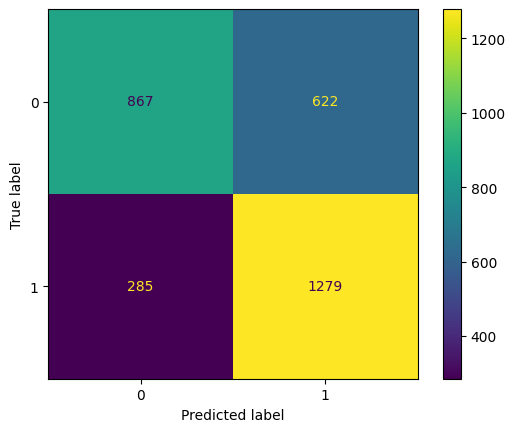

In [55]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds_of_test_data, labels=rf.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf.classes_,
                             )
disp.plot(values_format='');

The model is almost twice as likely to predict a false positive than it is to predict a false negative.

##### Feature importance

Use the `feature_importances_` attribute of the best estimator object to inspect the features of your final model. You can then sort them and plot the most important ones.

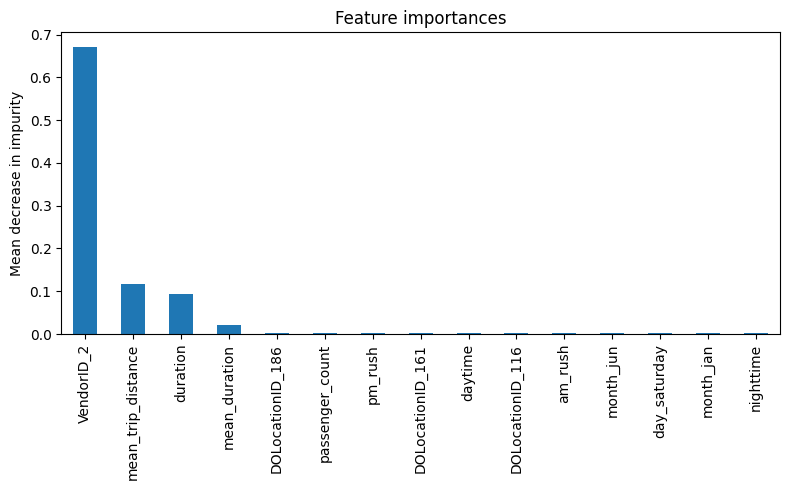

In [56]:
importances = rf.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

### **Task 4. Conclusion**

1. This is model performs acceptably. Its F1 score was 0.7558 and it had an overall accuracy of 0.7164. It correctly identified ~82% of the actual responders in the test set, which is 32% better than a random guess.

2. We know that VendorID, mean_trip_distance, and duration are the most important features, but we don't know how they influence tipping. And VendorID is the most predictive feature, it seems to indicate that one of the two vendors tends to attract more generous customers.